# Machine Learning - Classification <a class="tocSkip">

Build mechine learning model to predict the loan default

## Library 

In [92]:
# Load general utilities
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import os
from IPython import get_ipython
ipython = get_ipython()
# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Load sklearn utilities
import sklearn
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, \
roc_auc_score, roc_curve, precision_recall_curve, auc, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import feather

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

## Import data

In [2]:
# read data
start = time.time()
path = '/Users/cyuancheng/Documents/course/Springboard/Capstone1/data/'
df = pd.read_csv(path+'LC_ML_prep.csv', low_memory=False, index_col=0, \
                 parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d'] )
end = time.time()
print('It takes  ' + str(round((end-start)/60, 1)) +' min to read the data')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


It takes  0.2 min to read the data


In [4]:
# To ensure all the loans were matured, we only consider issue date before 2015 
df = df[df['issue_d']<'2015']

In [5]:
df.head()

,home_ownership,verification_status,purpose,addr_state,pub_rec,term_num,grade_num,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,log_delinq_2yrs,emp_length_num,Log_Annual_ROI,issue_d,earliest_cr_line,last_pymnt_d,target
1,MORTGAGE,Not Verified,debt_consolidation,TX,0.0,36,7,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,-inf,3.0,-1.346243,2013-12-01,2003-09-01,2016-06-01,0
2,OWN,Verified,debt_consolidation,MI,0.0,36,6,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,-inf,10.0,-1.193486,2013-12-01,1986-10-01,2016-07-01,0
3,RENT,Not Verified,debt_consolidation,NC,0.0,36,6,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,-inf,4.0,-1.167860,2013-12-01,2009-12-01,2016-04-01,0
5,MORTGAGE,Not Verified,debt_consolidation,CT,0.0,36,7,37.027454,6.62,21.6,12000.0,12000.0,368.45,12.0,764.0,13263.954639,5.021189,1.147676,4.119520,-inf,10.0,-1.481653,2013-12-01,1994-03-01,2017-01-01,0
6,RENT,Not Verified,debt_consolidation,NC,1.0,36,6,37.027454,12.85,81.9,14000.0,14000.0,470.71,6.0,674.0,16945.318783,4.944483,1.000868,3.566555,0.0,4.0,-1.194953,2013-12-01,1988-06-01,2017-01-01,0


In [6]:
df.shape

(286170, 26)

In [7]:
df['target'].value_counts(normalize=True)

0    0.907765
1    0.092235
Name: target, dtype: float64

It is computationally expensive to run ML models on this dataset, so we decide to randomly take a small portion of this dataset (20%).

In [8]:
# resample data (20%)
df_sam=df.sample(frac=0.2, replace=False, random_state=42)

In [10]:
df_sam.shape

(57234, 26)

## Feature Engineering

#### 1. datetime
Converting the datetime columns into integer number of year and month 

In [11]:
col_dt = df_sam.select_dtypes('datetime64').columns
print(col_dt)
print('number of datetime features =', len(col_dt))

Index(['issue_d', 'earliest_cr_line', 'last_pymnt_d'], dtype='object')
number of datetime features = 3


In [12]:
df_sam['issue_y']=pd.to_datetime(df_sam['issue_d']).apply(lambda x: int(x.strftime('%Y')))
df_sam['issue_m']=pd.to_datetime(df_sam['issue_d']).apply(lambda x: int(x.strftime('%m')))
df_sam['earliest_cr_line_y']=pd.to_datetime(df_sam['earliest_cr_line']).apply(lambda x: int(x.strftime('%Y')))
df_sam['earliest_cr_line_m']=pd.to_datetime(df_sam['earliest_cr_line']).apply(lambda x: int(x.strftime('%m')))
df_sam['last_pymnt_y']=pd.to_datetime(df_sam['last_pymnt_d']).apply(lambda x: int(x.strftime('%Y')))
df_sam['last_pymnt_m']=pd.to_datetime(df_sam['last_pymnt_d']).apply(lambda x: int(x.strftime('%m')))

In [13]:
# drop datetime columns
df_sam.drop(col_dt, axis=1, inplace=True)

#### 2. Categorical variable
one-hot encoding

In [24]:
col_cat = df_sam.select_dtypes('object').columns
print(col_cat)
print('number of categorical features =', len(col_cat))

Index(['home_ownership', 'verification_status', 'purpose', 'addr_state'], dtype='object')
number of categorical features = 4


In [25]:
#one-hot encoding
df_cat = pd.get_dummies(df_sam[col_cat],dummy_na=True)
df_cat.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,addr_state_AK,...,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
236609,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
273214,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83110,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
289411,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
364895,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 3. Numerical variable

In [26]:
col_num = df_sam.select_dtypes('float').columns 
print(col_num)
print('number of numerical feature =', len(col_num))

Index(['pub_rec', 'loan_period', 'int_rate', 'revol_util', 'loan_amnt',
       'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt',
       'log_annual_inc', 'log_dti', 'log_revol_bal', 'log_delinq_2yrs',
       'emp_length_num', 'Log_Annual_ROI'],
      dtype='object')
number of numerical feature = 16


In [27]:
col_int = df_sam.select_dtypes('int64').columns 
print(col_int)

Index(['term_num', 'grade_num', 'target', 'issue_y', 'issue_m',
       'earliest_cr_line_y', 'earliest_cr_line_m', 'last_pymnt_y',
       'last_pymnt_m'],
      dtype='object')


In [28]:
df_num = pd.concat((df_sam[col_num], df_sam[col_int]),axis=1)
df_num.drop(['log_delinq_2yrs'], axis=1, inplace=True) # drop this feature, because it contains infinity.
df_num.head()

,pub_rec,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,emp_length_num,Log_Annual_ROI,term_num,grade_num,target,issue_y,issue_m,earliest_cr_line_y,earliest_cr_line_m,last_pymnt_y,last_pymnt_m
236609,0.0,20.994271,17.57,74.8,13325.0,13325.0,335.26,9.0,684.0,7040.460000,4.623249,1.319938,4.131587,5.0,-0.514900,60,4,1,2014,10,1999,7,2016,7
273214,0.0,25.035422,10.99,37.4,4000.0,4000.0,130.94,10.0,669.0,3295.080000,4.318063,1.154120,3.830781,0.0,-1.051898,36,6,1,2014,8,2009,10,2016,9
83110,0.0,16.000329,17.77,75.6,25000.0,25000.0,900.93,13.0,669.0,29911.816859,4.778151,1.211121,4.464936,2.0,-0.841639,36,4,0,2013,6,2004,4,2014,10
289411,0.0,32.000657,12.99,23.7,9125.0,9125.0,307.42,11.0,724.0,11040.748611,4.322219,1.211921,4.033142,3.0,-1.130301,36,5,0,2014,7,2002,3,2017,3
364895,0.0,36.008953,8.90,77.5,9600.0,9600.0,304.84,8.0,669.0,10973.863349,4.829304,1.351216,3.979002,2.0,-1.341210,36,7,0,2014,3,2005,5,2017,3


In [29]:
df_num.shape

(57234, 24)

### Feature Selection

#### 1. Eliminate correlated features 

- From the Pearson correlation heatmap, we found that for prediction on default as target, the annual ROI is the most predicative of all features, followed by grade and interest rate.
- To avoid overfitting, we eliminated the features that are highly correlated with each other, and only keep the following features.  (multicollinearity)
 

#### - Eliminate feature that is uncorrelated with target

In [30]:
#Correlation with output variable
cor = df_num.corr()
cor_target = abs(cor["target"])

# only keep correlation >0.01 with target
relevant_features = cor_target[cor_target>0.01] 
relevant_features.sort_values(ascending=False)

target                1.000000
Log_Annual_ROI        0.218407
grade_num             0.147384
int_rate              0.144329
total_pymnt           0.141385
term_num              0.128738
fico                  0.067889
loan_amnt             0.059655
funded_amnt           0.059569
log_dti               0.055431
loan_period           0.054784
log_annual_inc        0.048095
last_pymnt_y          0.032569
installment           0.029248
revol_util            0.027951
issue_y               0.022103
earliest_cr_line_y    0.021695
open_acc              0.016149
log_revol_bal         0.014850
pub_rec               0.013649
Name: target, dtype: float64

In [31]:
# list relevant features
list_feature = relevant_features.to_frame().index.to_list()
print(list_feature)

['pub_rec', 'loan_period', 'int_rate', 'revol_util', 'loan_amnt', 'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt', 'log_annual_inc', 'log_dti', 'log_revol_bal', 'Log_Annual_ROI', 'term_num', 'grade_num', 'target', 'issue_y', 'earliest_cr_line_y', 'last_pymnt_y']


#### - Eliminate feature that is higly correlated with each other (multicollinearity)

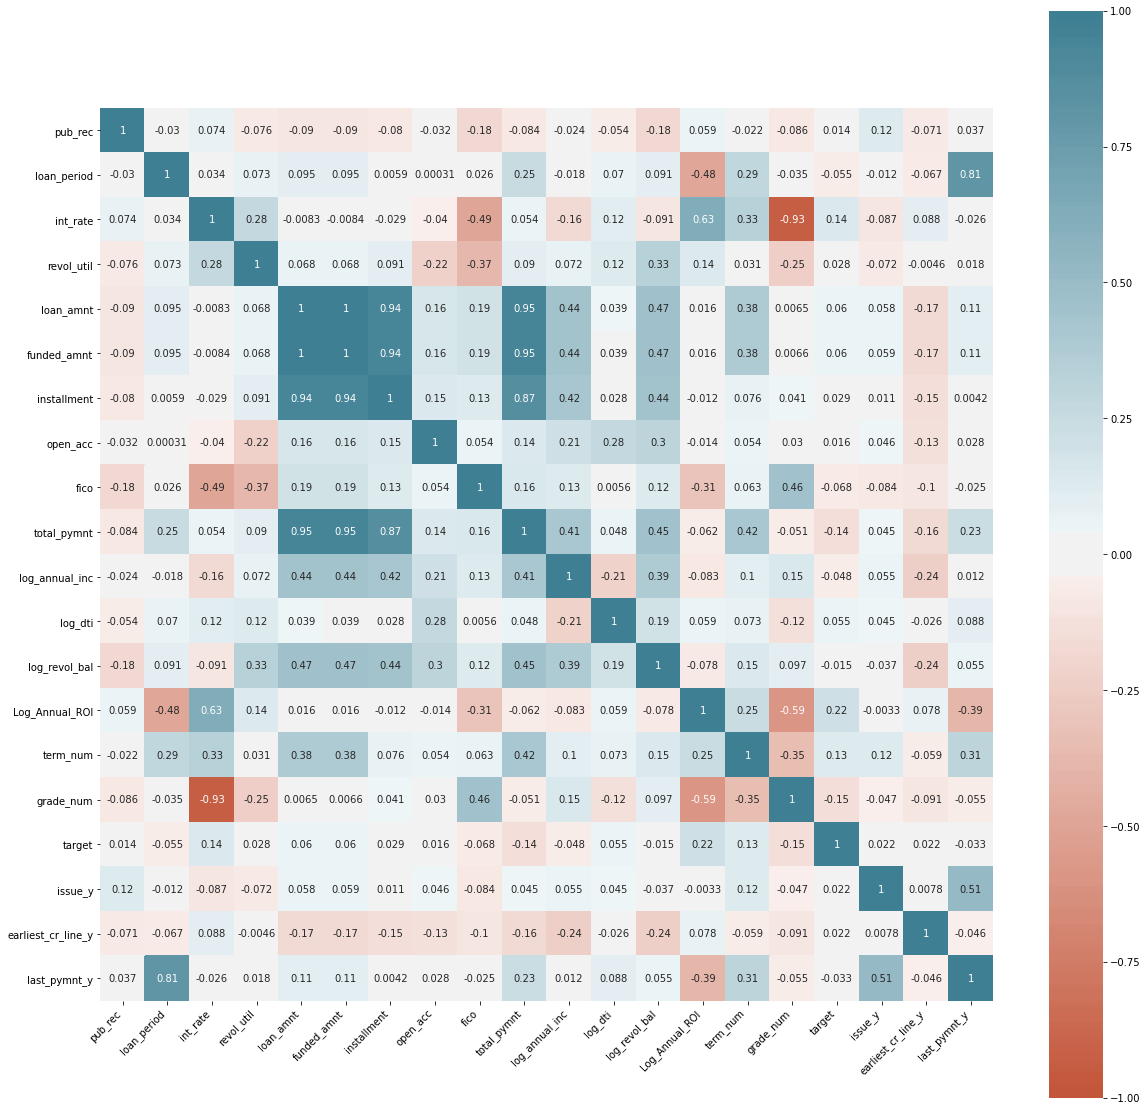

In [32]:
# heatmap

plt.figure(figsize=(20,20))

ax = sns.heatmap(
    df_num[list_feature].corr(), 
    vmin=-1, vmax=1, center=0,annot = True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

remove funded_amnt, installment, total_paymnt, grade_num, last_pymnt_y

In [33]:
list_feature.remove('funded_amnt')
list_feature.remove('installment')
list_feature.remove('total_pymnt')
list_feature.remove('grade_num')
list_feature.remove('last_pymnt_y')

In [34]:
list_feature

['pub_rec',
 'loan_period',
 'int_rate',
 'revol_util',
 'loan_amnt',
 'open_acc',
 'fico',
 'log_annual_inc',
 'log_dti',
 'log_revol_bal',
 'Log_Annual_ROI',
 'term_num',
 'target',
 'issue_y',
 'earliest_cr_line_y']

In [35]:
# combine numerical variable and categorical variable
df_feature = pd.concat((df_sam[list_feature], df_cat),axis=1)
df_feature.drop(['target'], axis=1, inplace=True) 
df_feature.head()

,pub_rec,loan_period,int_rate,revol_util,loan_amnt,open_acc,fico,log_annual_inc,log_dti,log_revol_bal,Log_Annual_ROI,term_num,issue_y,earliest_cr_line_y,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,purpose_car,...,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
236609,0.0,20.994271,17.57,74.8,13325.0,9.0,684.0,4.623249,1.319938,4.131587,-0.514900,60,2014,1999,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
273214,0.0,25.035422,10.99,37.4,4000.0,10.0,669.0,4.318063,1.154120,3.830781,-1.051898,36,2014,2009,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83110,0.0,16.000329,17.77,75.6,25000.0,13.0,669.0,4.778151,1.211121,4.464936,-0.841639,36,2013,2004,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
289411,0.0,32.000657,12.99,23.7,9125.0,11.0,724.0,4.322219,1.211921,4.033142,-1.130301,36,2014,2002,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
364895,0.0,36.008953,8.90,77.5,9600.0,8.0,669.0,4.829304,1.351216,3.979002,-1.341210,36,2014,2005,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
# set X, y
X=df_feature 
y=df_sam['target']

### Train test split

Split into test and train sets BEFORE oversampling

In [37]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [38]:
# Standarization (before resampling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Oversampling by SMOTE
- Oversampling the training set using Synthetic Minority Oversampling Technique ([SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html))
- Standarization after SMOTE
 - fit_transform on training data, transform on test data

In [39]:
# load imbalanced-learn
from imblearn.over_sampling import SMOTE

In [40]:
start = time.time()
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
end= time.time()
print('It takes  ' + str(round((end-start), 1)) +' sec')

It takes  3.5 sec


In [41]:
# Standarization (after resampling)
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

In [42]:
# without oversampling
values, counts = np.unique(y_train, return_counts=True)
print(values, counts)

[0 1] [41579  4208]


In [43]:
# after oversampling
values, counts = np.unique(y_train_res, return_counts=True)
print(values, counts)

[0 1] [41579 41579]


### Learning Curve
Use the learning curve to see how the select model learning with increasing the sample size. Use Logestic Regression as an example


In [44]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(10,5))
    plt.title(title)
    #plt.ylim(ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score (AUC)")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt


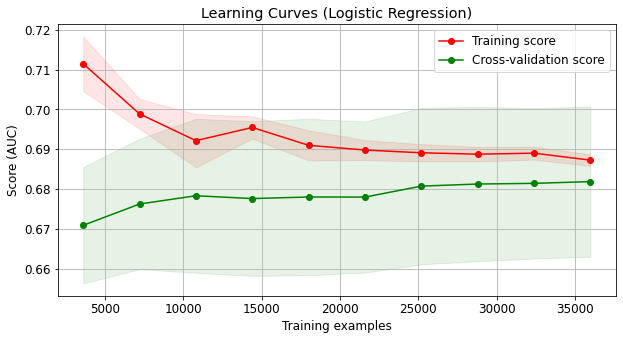

In [45]:
X, y = X_train_res[:40000], y_train_res[:40000]
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean train and validation set
# score curves, each time with 1/10 data randomly selected as a validation set.
plot_learning_curve(LogisticRegression(), title, X, y, cv=10, n_jobs=1)
plt.show()

### Model evaluation function
- use stratified k fold cross validation to avoid overfit
- use confusion matrix and auc_ruc to evaluate model performance
- model selection: baseline, logistic regression, svm, naive bayes, random forest, booster


In [46]:
def evaluation_model(model, X_train, y_train, X_test, y_test):
    
    target_names = ['Non-Defaulted Loan','Defaulted Loan']
    y_pred = model.predict(X_test)
    
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_pred)))
    print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred, \
                                                                            target_names=target_names)))
    print("Accuracy Score: {0:.4f}\n".format(accuracy_score(y_test,  y_pred)))    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    auc_test = cross_val_score(model, X_test, y_test, cv=cv, scoring='roc_auc')
    print("Stratified KFold Cross Validation:\n")
    print("--Training Set--")
    print("Mean AUC (cv): \t {0:.4f}".format(np.mean(auc_train)))
    print("SD AUC: \t\t {0:.4f}".format(np.std(auc_train)))
    print("--Test Set--")
    print("Mean AUC (cv): \t {0:.4f}".format(np.mean(auc_test)))
    print("SD AUC: \t\t {0:.4f}".format(np.std(auc_test)))

####  ROC Curve plot function
We used this function to plot ROC Curve for all the models. 

In [47]:
def auc_ruc(X_test, y_test, title, model):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc=roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    print('AUC=', auc)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.plot(fpr, tpr, 'r', lw=2,\
             label='AUC = %0.2f'% auc )
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--', lw=2)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [48]:
def auc_ruc_res(X_test, y_test, model, model_res):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1],
                                         pos_label=1)
    fpr_res, tpr_res, thresholds_res = roc_curve(y_test, model_res.predict_proba(X_test)[:,1],
                                         pos_label=1)
    auc=roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    auc_res=roc_auc_score(y_test,model_res.predict_proba(X_test)[:,1])
    print('AUC=',auc)
    print('AUC_rec=', auc_res)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', \
             label='AUC (imbalance data) = %0.2f'% auc )
    plt.plot(fpr_res, tpr_res, 'r', \
             label='AUC (SMOTE) = %0.2f'% auc_res )
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Model
### Baseline model (DummyClassifier)
- Use a baseline model to evaluate and compare the model performance. 
- use [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) to predict the majority class in the data


In [49]:
# define the reference model
from sklearn.dummy import DummyClassifier

model_baseline = DummyClassifier(strategy='stratified')
model_baseline_res = DummyClassifier(strategy='stratified')

__without SMOTE__

In [50]:
model_baseline.fit(X_train, y_train)
evaluation_model(model_baseline, X_train, y_train, X_test, y_test)

Confusion Matrix: 
 [[9454  915]
 [ 974  104]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.91      0.91      0.91     10369
    Defaulted Loan       0.10      0.10      0.10      1078

          accuracy                           0.83     11447
         macro avg       0.50      0.50      0.50     11447
      weighted avg       0.83      0.83      0.83     11447


Accuracy Score: 0.8350

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.5015
SD AUC: 		 0.0068
--Test Set--
Mean AUC (cv): 	 0.5017
SD AUC: 		 0.0154


__with SMOTE__

In [51]:
model_baseline_res.fit(X_train_res, y_train_res)
evaluation_model(model_baseline_res, X_train_res, y_train_res, X_test, y_test)

Confusion Matrix: 
 [[5215 5154]
 [ 521  557]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.91      0.50      0.65     10369
    Defaulted Loan       0.10      0.52      0.16      1078

          accuracy                           0.50     11447
         macro avg       0.50      0.51      0.41     11447
      weighted avg       0.83      0.50      0.60     11447


Accuracy Score: 0.5042

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.5005
SD AUC: 		 0.0045
--Test Set--
Mean AUC (cv): 	 0.4990
SD AUC: 		 0.0166


AUC= 0.4985060095106525
AUC_rec= 0.49933756983272715


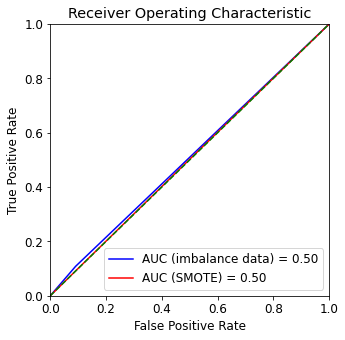

In [52]:
auc_ruc_res(X_test, y_test, model_baseline, model_baseline_res)

### Logistic Regression

__without SMOTE__

In [53]:
logisticModel_0 = LogisticRegression()
logisticModel_0.fit(X_train,y_train)

LogisticRegression()

In [54]:
scores_LR = evaluation_model(logisticModel_0, X_train, y_train, X_test, y_test)

Confusion Matrix: 
 [[10369     0]
 [ 1078     0]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.91      1.00      0.95     10369
    Defaulted Loan       0.00      0.00      0.00      1078

          accuracy                           0.91     11447
         macro avg       0.45      0.50      0.48     11447
      weighted avg       0.82      0.91      0.86     11447


Accuracy Score: 0.9058



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.6804
SD AUC: 		 0.0153
--Test Set--
Mean AUC (cv): 	 0.6874
SD AUC: 		 0.0262


__with SMOTE__

In [55]:
logisticModel_res = LogisticRegression()
logisticModel_res.fit(X_train_res,y_train_res)

LogisticRegression()

In [56]:
scores_LR_res = evaluation_model(logisticModel_res, X_train_res, y_train_res, X_test, y_test)

Confusion Matrix: 
 [[6933 3436]
 [ 387  691]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.95      0.67      0.78     10369
    Defaulted Loan       0.17      0.64      0.27      1078

          accuracy                           0.67     11447
         macro avg       0.56      0.65      0.52     11447
      weighted avg       0.87      0.67      0.74     11447


Accuracy Score: 0.6660

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.7351
SD AUC: 		 0.0055
--Test Set--
Mean AUC (cv): 	 0.6874
SD AUC: 		 0.0262


AUC= 0.6876794519699884
AUC_rec= 0.7120180908877987


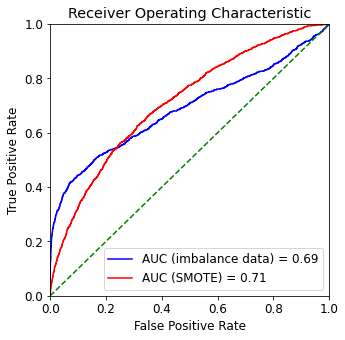

In [57]:
auc_ruc_res(X_test, y_test, logisticModel_0, logisticModel_res)

### Logistic Regression (Grid Search)

Use random grid search to do hyperparameter tuning and to minimize false negatives. 

In [58]:
from sklearn.model_selection import GridSearchCV
def cv_best_parameters(model, param_grid):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid = GridSearchCV(model, param_grid,cv=cv, scoring='roc_auc')
    X=X_train_res
    y=y_train_res
    grid.fit(X,y)
    return grid.best_params_, grid.best_score_,grid.best_estimator_

In [59]:
# hyperparameter tuning
logreg_cv = LogisticRegression(random_state=42)
c=[0.01, 0.1, 1, 10, 100, 200]
param_grid = dict(C=c)
Best_params, Best_AUC, Best_classifier = cv_best_parameters(logreg_cv,param_grid)
print("Best AUC = "+ str(Best_AUC))
print(Best_classifier)

Best AUC = 0.735097065841666
LogisticRegression(C=1, random_state=42)


In [60]:
clf_LR = LogisticRegression(C=1, random_state=42)
clf_LR.fit(X_train_res,y_train_res)

evaluation_model(clf_LR, X_train_res, y_train_res, X_test, y_test)

Confusion Matrix: 
 [[6933 3436]
 [ 387  691]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.95      0.67      0.78     10369
    Defaulted Loan       0.17      0.64      0.27      1078

          accuracy                           0.67     11447
         macro avg       0.56      0.65      0.52     11447
      weighted avg       0.87      0.67      0.74     11447


Accuracy Score: 0.6660

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.7351
SD AUC: 		 0.0055
--Test Set--
Mean AUC (cv): 	 0.6874
SD AUC: 		 0.0262


AUC= 0.7120180908877987


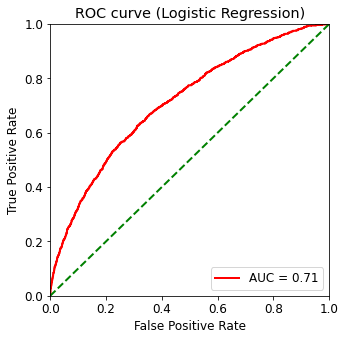

In [61]:
auc_ruc(X_test, y_test, 'ROC curve (Logistic Regression)',clf_LR)

### Naive Bayes (Grid Search)

In [62]:
# hyperparameter tuning
NaiveBayes_cv = BernoulliNB()
alpha=[0.1, 0.5,1,5,10]
param_grid = dict(alpha=alpha)
Best_params, Best_AUC, Best_classifier = cv_best_parameters(NaiveBayes_cv,param_grid)
print("Best AUC = "+ str(Best_AUC))
print(Best_classifier)

Best AUC = 0.7308472185555229
BernoulliNB(alpha=0.1)


In [63]:
clf_NB = BernoulliNB(alpha=Best_classifier.alpha)
clf_NB.fit(X_train_res,y_train_res)

evaluation_model(clf_NB , X_train_res, y_train_res, X_test, y_test)                     

Confusion Matrix: 
 [[6920 3449]
 [ 357  721]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.95      0.67      0.78     10369
    Defaulted Loan       0.17      0.67      0.27      1078

          accuracy                           0.67     11447
         macro avg       0.56      0.67      0.53     11447
      weighted avg       0.88      0.67      0.74     11447


Accuracy Score: 0.6675

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.7308
SD AUC: 		 0.0052
--Test Set--
Mean AUC (cv): 	 0.7146
SD AUC: 		 0.0190


AUC= 0.7159416778749129


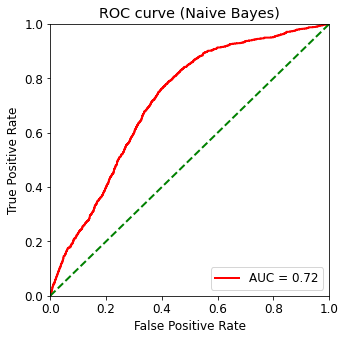

In [64]:
auc_ruc(X_test, y_test, 'ROC curve (Naive Bayes)', clf_NB)

### K Nearest Neighbors (Grid Search)

In [65]:
start = time.time()
knn_cv = KNeighborsClassifier()
k_range = [5,10,20]
param_grid = dict(n_neighbors=k_range)

Best_params, Best_AUC, Best_classifier = cv_best_parameters(knn_cv,param_grid)
print("Best AUC = "+ str(Best_AUC))
print(Best_classifier)
end=time.time()
print('It takes  ' + str(round((end-start)/60, 1)) +' min')

Best AUC = 0.9659890738183157
KNeighborsClassifier(n_neighbors=10)
It takes  88.2 min


In [66]:
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train_res,y_train_res)

evaluation_model(clf_knn , X_train_res, y_train_res, X_test, y_test)  

Confusion Matrix: 
 [[7377 2992]
 [ 512  566]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.94      0.71      0.81     10369
    Defaulted Loan       0.16      0.53      0.24      1078

          accuracy                           0.69     11447
         macro avg       0.55      0.62      0.53     11447
      weighted avg       0.86      0.69      0.75     11447


Accuracy Score: 0.6939

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.9660
SD AUC: 		 0.0017
--Test Set--
Mean AUC (cv): 	 0.6123
SD AUC: 		 0.0281


AUC= 0.666024932316626


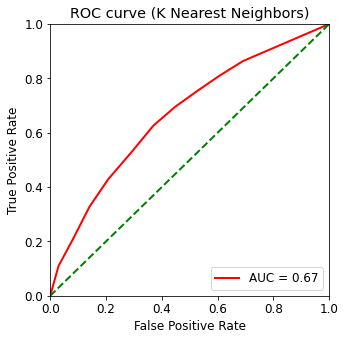

In [67]:
auc_ruc(X_test, y_test, 'ROC curve (K Nearest Neighbors)', clf_knn)

### Random Forest (Grid Search)

In [68]:
RF_cv = RandomForestClassifier(random_state=42)

n_estimators = [20,50,100,200]

param_grid = dict(n_estimators=n_estimators)

Best_params, Best_AUC, Best_classifier = cv_best_parameters(RF_cv,param_grid)
print("Best AUC = "+ str(Best_AUC))
print(Best_classifier)

Best AUC = 0.9993585496489029
RandomForestClassifier(n_estimators=200, random_state=42)


In [97]:
Best_params

{'n_estimators': 300}

In [69]:
clf_RF = RandomForestClassifier(n_estimators=200, random_state=42)
clf_RF.fit(X_train_res,y_train_res)

evaluation_model(clf_RF , X_train_res, y_train_res, X_test, y_test) 

Confusion Matrix: 
 [[10356    13]
 [  350   728]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.97      1.00      0.98     10369
    Defaulted Loan       0.98      0.68      0.80      1078

          accuracy                           0.97     11447
         macro avg       0.97      0.84      0.89     11447
      weighted avg       0.97      0.97      0.97     11447


Accuracy Score: 0.9683

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.9994
SD AUC: 		 0.0002
--Test Set--
Mean AUC (cv): 	 0.9600
SD AUC: 		 0.0098


AUC= 0.969706422973717


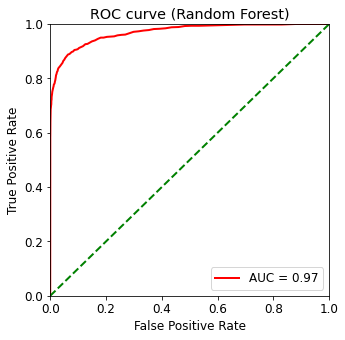

In [70]:
auc_ruc(X_test, y_test, 'ROC curve (Random Forest)', clf_RF)

#### Feature importance

Text(0.5, 0, 'Normalized Gini Importance')

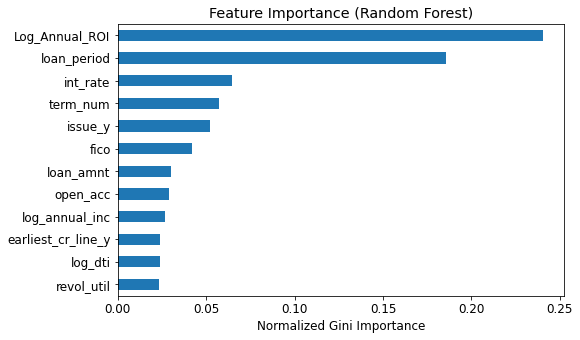

In [71]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,5))
feat_importances = pd.Series(clf_RF.feature_importances_, \
                             index=df_feature.columns)
feat_importances.nlargest(12).sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Normalized Gini Importance')

### Gradient Boosting (Grid Search)

In [72]:
GB_cv = GradientBoostingClassifier()

n_estimators = [50,100,200,300]
param_grid = dict(n_estimators=n_estimators)

Best_params, Best_AUC, Best_classifier = cv_best_parameters(GB_cv,param_grid)
print("Best AUC = "+ str(Best_AUC))

print(Best_classifier)

Best AUC = 0.9978472594380172
GradientBoostingClassifier(n_estimators=300)


In [73]:
clf_GB = GradientBoostingClassifier(n_estimators=300)
clf_GB.fit(X_train_res,y_train_res)

evaluation_model(clf_GB, X_train_res, y_train_res, X_test, y_test)

Confusion Matrix: 
 [[10351    18]
 [  246   832]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.98      1.00      0.99     10369
    Defaulted Loan       0.98      0.77      0.86      1078

          accuracy                           0.98     11447
         macro avg       0.98      0.89      0.93     11447
      weighted avg       0.98      0.98      0.98     11447


Accuracy Score: 0.9769

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.9978
SD AUC: 		 0.0003
--Test Set--
Mean AUC (cv): 	 0.9816
SD AUC: 		 0.0083


AUC= 0.9798638942860042


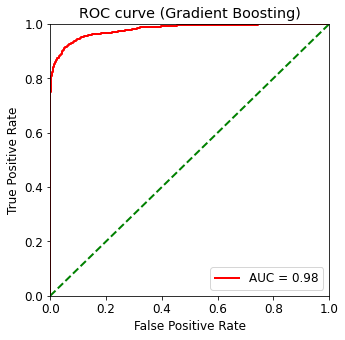

In [74]:
auc_ruc(X_test, y_test, 'ROC curve (Gradient Boosting)', clf_GB)

In [75]:
# save models
import pickle

# save the model to disk
pickle.dump(model_baseline_res, open('baseline_cls.sav', 'wb'))
pickle.dump(clf_knn, open('knn_cls.sav', 'wb'))
pickle.dump(clf_LR, open('LR_cls.sav', 'wb'))
pickle.dump(clf_NB, open('NB_cls.sav', 'wb'))
pickle.dump(clf_RF, open('RF_cls.sav', 'wb'))
pickle.dump(clf_GB, open('GB_cls.sav', 'wb'))

In [76]:
# load models
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Model Performance


In [77]:
name_list = ['baseline','KNN','Logistic Regression', 'Naive Bayes', 'Random Forest', 'Gradient Boosting']
model_load = [model_baseline_res, clf_knn, clf_LR, clf_NB, clf_RF, clf_GB]

In [78]:
fpr_list = dict()
tpr_list = dict()
auc_list = dict()
precision_list = dict()
recall_list = dict()
auc_pr_list = dict()
for i,j in enumerate(name_list):
    print(i,j)
    print(model_load[i])
    y_pred = model_load[i].predict_proba(X_test)[:,1]
    fpr_list[j], tpr_list[j], _ = roc_curve(y_test, y_pred)
    auc_list[j]=roc_auc_score(y_test, y_pred)
    precision_list[j], recall_list[j], _ = precision_recall_curve(y_test, y_pred)
    auc_pr_list[j] = auc(recall_list[j], precision_list[j])

0 baseline
DummyClassifier(strategy='stratified')
1 KNN
KNeighborsClassifier(n_neighbors=10)
2 Logistic Regression
LogisticRegression(C=1, random_state=42)
3 Naive Bayes
BernoulliNB(alpha=0.1)
4 Random Forest
RandomForestClassifier(n_estimators=200, random_state=42)
5 Gradient Boosting
GradientBoostingClassifier(n_estimators=300)


In [79]:
color_rgb =[(114,158,206), (255,158,74), (103,191,92),(237,102,93),(173,139,201),(205,204,93),(65,68,81)]
color_hex=['#729ece','#ff9e4a','#67bf5c','#ed665d','#ad8bc9','#cdcc5d','#414451']
'#%02x%02x%02x' % (205,204,93)

'#cdcc5d'

In [83]:
print(name_list)

['baseline', 'KNN', 'Logistic Regression', 'Naive Bayes', 'Random Forest', 'Gradient Boosting']


KNN #729ece
Logistic Regression #ff9e4a
Naive Bayes #67bf5c
Random Forest #ed665d
Gradient Boosting #ad8bc9


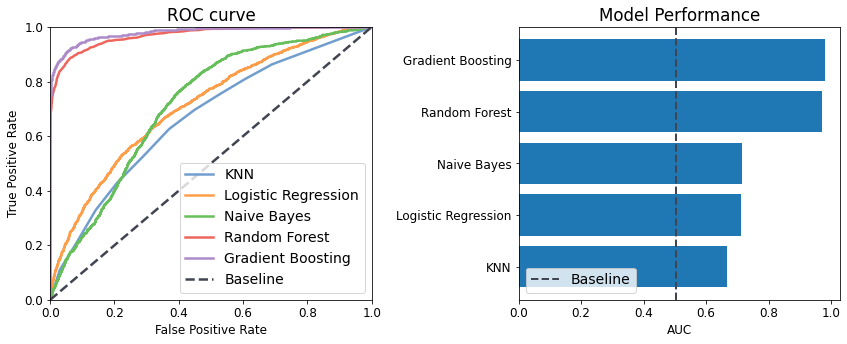

In [81]:
# Plotting the bars
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(6,6))
#color_hex=['#729ece','#ff9e4a','#67bf5c','#ed665d','#ad8bc9','#414451']
for i,j in enumerate(name_list[1:]):
    print(j, color_hex[i])
    ax1.plot(fpr_list[j], tpr_list[j], color=color_hex[i],label=j, lw=2.5)

ax1.plot([0, 1], [0, 1], color=color_hex[6], lw=2.5, linestyle='--', label='Baseline')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve') #Receiver Operating Characteristic 
ax1.legend(loc="lower right")

ax2.barh(list(auc_list.keys())[1:],list(auc_list.values())[1:])
ax2.axvline(list(auc_list.values())[0], color=color_hex[6], lw=2, linestyle='--', label='Baseline')
ax2.set_xlabel('AUC')
ax2.set_title('Model Performance')
ax2.legend(loc="lower left")

plt.tight_layout()

KNN #729ece
Logistic Regression #ff9e4a
Naive Bayes #67bf5c
Random Forest #ed665d
Gradient Boosting #ad8bc9


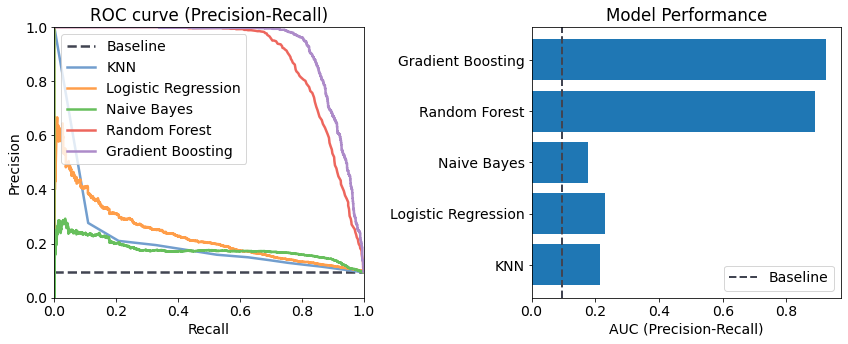

In [84]:

# Plotting the bars
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

plt.rcParams.update({'font.size': 14})

no_skill = len(y_test[y_test==1])/len(y_test) # postive class rationo_skill
ax1.plot([0,1],[no_skill, no_skill], color=color_hex[6], lw=2.5, linestyle='--', label='Baseline')

for i,j in enumerate(name_list[1:]):
    print(j, color_hex[i])
    ax1.plot(recall_list[j], precision_list[j], color=color_hex[i],label=j, lw=2.5)
    
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('ROC curve (Precision-Recall)') #Receiver Operating Characteristic 
ax1.legend(loc="best")

ax2.barh(list(auc_pr_list.keys())[1:],list(auc_pr_list.values())[1:])
ax2.axvline(no_skill , color=color_hex[6], lw=2, linestyle='--', label='Baseline')
ax2.set_xlabel('AUC (Precision-Recall)')
ax2.set_title('Model Performance')
ax2.legend()
plt.tight_layout()

In [85]:
no_skill

0.09417314580239364

In [86]:
df_feature.head()

,pub_rec,loan_period,int_rate,revol_util,loan_amnt,open_acc,fico,log_annual_inc,log_dti,log_revol_bal,Log_Annual_ROI,term_num,issue_y,earliest_cr_line_y,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,purpose_car,...,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
236609,0.0,20.994271,17.57,74.8,13325.0,9.0,684.0,4.623249,1.319938,4.131587,-0.514900,60,2014,1999,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
273214,0.0,25.035422,10.99,37.4,4000.0,10.0,669.0,4.318063,1.154120,3.830781,-1.051898,36,2014,2009,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83110,0.0,16.000329,17.77,75.6,25000.0,13.0,669.0,4.778151,1.211121,4.464936,-0.841639,36,2013,2004,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
289411,0.0,32.000657,12.99,23.7,9125.0,11.0,724.0,4.322219,1.211921,4.033142,-1.130301,36,2014,2002,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
364895,0.0,36.008953,8.90,77.5,9600.0,8.0,669.0,4.829304,1.351216,3.979002,-1.341210,36,2014,2005,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Explainability of ML model

The best model is Gradient Boosting. Use the best performance classifier to find the feature importance using Permutation

In [101]:
import shap
explainer = shap.TreeExplainer(clf_GB)
shap_values = explainer.shap_values(df_feature)

In [105]:
#initiatize JavaScript visulization
shap.initjs()

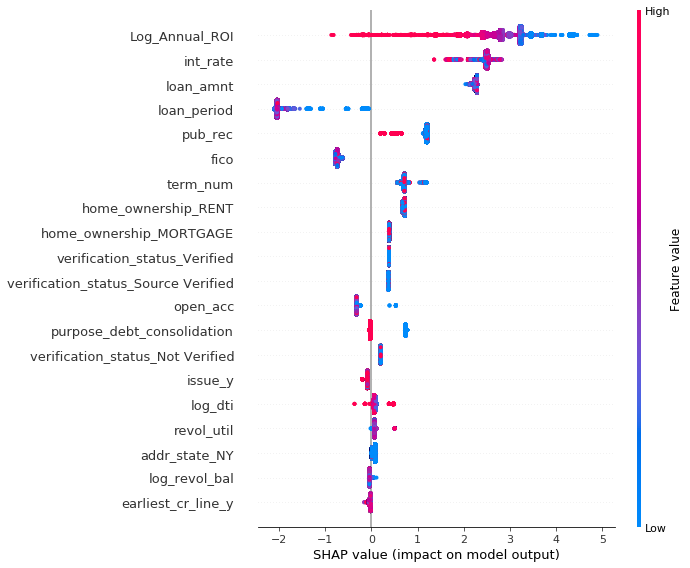

In [102]:
# Plot summary_plot
shap.summary_plot(shap_values, df_feature)

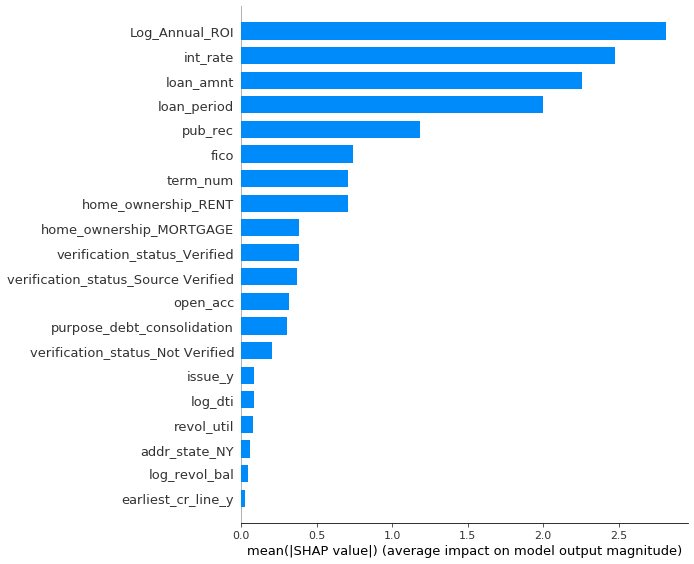

In [103]:
# Plot summary_plot
shap.summary_plot(shap_values, df_feature, plot_type='bar')

In [106]:
shap.force_plot(explainer.expected_value, shap_values[0,:], df_feature.iloc[0,:])

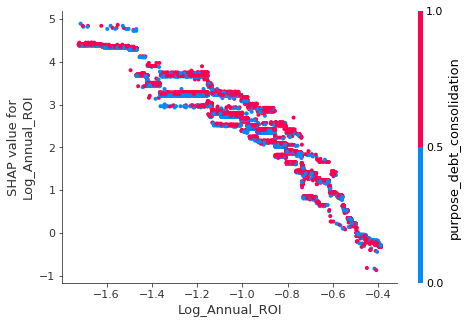

In [129]:
shap.dependence_plot("Log_Annual_ROI", shap_values, df_feature)

In [113]:
shap_interaction_values = explainer.shap_interaction_values(df_feature)

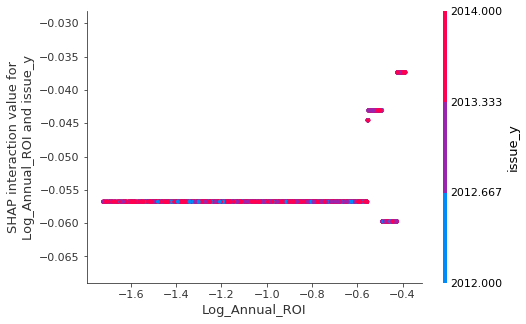

In [125]:
shap.dependence_plot(("Log_Annual_ROI", "issue_y"),shap_interaction_values, df_feature)

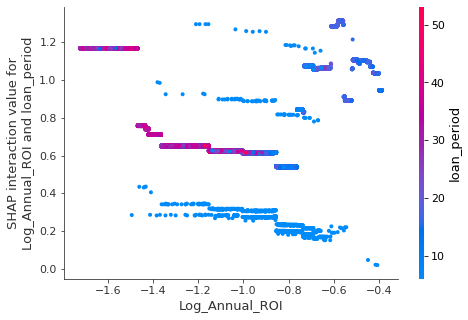

In [120]:
shap.dependence_plot(("Log_Annual_ROI", "loan_period"),shap_interaction_values, df_feature)